# Tomer and Nir 2024 IMU project
##### Function Declaration:

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from snn.resonator import test_resonator_on_chirp, create_chirp_signal, trained_resonator, simple_resonator

def plot_emitted_spikes(network, x_stop, nid=-1, label=None):
    spikes_neuron = network.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
    x = np.linspace(0, x_stop, len(y_spikes))
    plt.title('Resonator Output')
    plt.ylabel('Spikes per W500')
    plt.xlabel('Frequency')
    plt.plot(x, y_spikes)

# same, but adds legend (takes x2 more time)    
def plot_emitted_spikes_modified(network, x_stop, freq, nid=-1, label=None):
    spikes_neuron = network.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
    x = np.linspace(0, x_stop, len(y_spikes))

    # Plot the data and get a reference to the line object
    line, = plt.plot(x, y_spikes, label=f'Frequency: {freq}')

    # Set plot labels and title
    plt.title('Resonator Output')
    plt.ylabel('Spikes per 500')
    plt.xlabel('Frequency')

    # Create or update the legend
    lines, labels = plt.gca().get_legend_handles_labels()
    if f'Frequency: {freq}' not in labels:
        lines.append(line)
        labels.append(f'Frequency: {freq}')
    plt.legend(lines, labels)
# Call this function to display the plot without closing it
plt.show(block=False)
   
def resonator_output_spikes_on_chirp(my_resonator, freq0, clk_freq, save_figure=False,  neurons_log_potentials=None, neurons_log_spikes=None, step=None):
    neurons_log_potentials = neurons_log_potentials or []
    for i in neurons_log_potentials:
        my_resonator.log_membrane_potential(i)

    neurons_log_spikes = neurons_log_spikes or []
    for i in neurons_log_spikes:
        my_resonator.log_out_spikes(i)

    start_freq = 0
    spectrum = 4*freq0
    step = step or 1/clk_freq
    test_size = int(spectrum / step)

    print(start_freq, step, test_size, clk_freq)
    test_resonator_on_chirp(
        my_resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
    )

    for i in neurons_log_potentials:
        membrane_neuron = my_resonator.neurons[i]
        y_membrane = membrane_neuron.membrane_potential_graph()
        x = np.linspace(start_freq, start_freq + spectrum, len(y_membrane))
        plt.title(f'membrane potential f={freq0}, neuron={i}')
        plt.plot(x, y_membrane)
        plt.show()

    spikes_window_size = 500
    for i in neurons_log_spikes:
        spikes_neuron = my_resonator.neurons[i]
        y_events = spikes_neuron.out_spikes()
        y_spikes = np.zeros(test_size)
        y_spikes[y_events] = 1
        y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
        x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
        plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
        if save_figure:
            plt.savefig('plot.png', dpi=300, bbox_inches='tight')
            plt.close()
        else:
            plt.plot(x, y_spikes)
            plt.show()
            
def test_frequency(network, test_size=10_000_000, start_freq=0, step=1 / 200000, clk_freq=1536000):
    batch_size = 50_000
    shift = 0
    while test_size > 0:
        sine_size = min(batch_size, test_size)
        sine_wave, freqs = create_chirp_signal(sine_size, clk_freq, start_freq, step, shift)

        network.input_full_data(sine_wave)

        shift = freqs[-1]
        start_freq += sine_size * step
        test_size -= sine_size
             
def custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=1, step = None, save_figure=False, path=None, plot=True, c=None):
    resonator.log_out_spikes(-1)
    start_freq = freq0/2
    spectrum = freq0
    step = step or 1 / clk_freq / sample_rate
    test_size = int(spectrum / step)
    spikes_neuron = resonator.neurons[-1]

    spikes_neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
    test_frequency(
        resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
   )

    events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(events[-1] + 1)
    y_spikes[events] = 1

    if path is not None:
        np.savez_compressed(path, spikes=y_spikes)

    spikes_window_size = 500
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
    # plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
    plt.plot(x, y_spikes, label=freq0, c=c)
    if save_figure:
        plt.savefig(f'../filters/clk_{clk_freq}/figures/f_{freq0:.3f}.PNG', bbox_inches='tight')
        plt.close()
    elif plot:
        plt.show()
        

#Parameters:
clk_freq=1536000
spectrum = 300
step = 1/20000  # To reduce running time, increase step
test_size = int(spectrum / step)

# Resonator Checks:
#### The main objective is to check that we have full coverage of the spectrum

30.5 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_30.5.json
Thetas:  [-37.124, -32.549, -29.814, -29.008] , Weights: [123.204, 50.851, 64.454, 59.25, 58.383] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  30.5 f_clk = 153600 Leakage Period is: 49
63.6 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_63.6.json
Thetas:  [-98.054, -70.205, -64.087, -57.686] , Weights: [294.356, 103.068, 140.527, 124.915, 116.543] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  63.6 f_clk = 153600 Leakage Period is: 23
95.4 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_95.4.json
Thetas:  [-117.549, -100.74, -96.393, -85.843] , Weights: [387.993, 160.185, 197.341, 190.822, 177.199] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  95.4 f_clk = 153600 Leakage Period is: 15
160 Type:  <class 'int'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_160.json
Theta

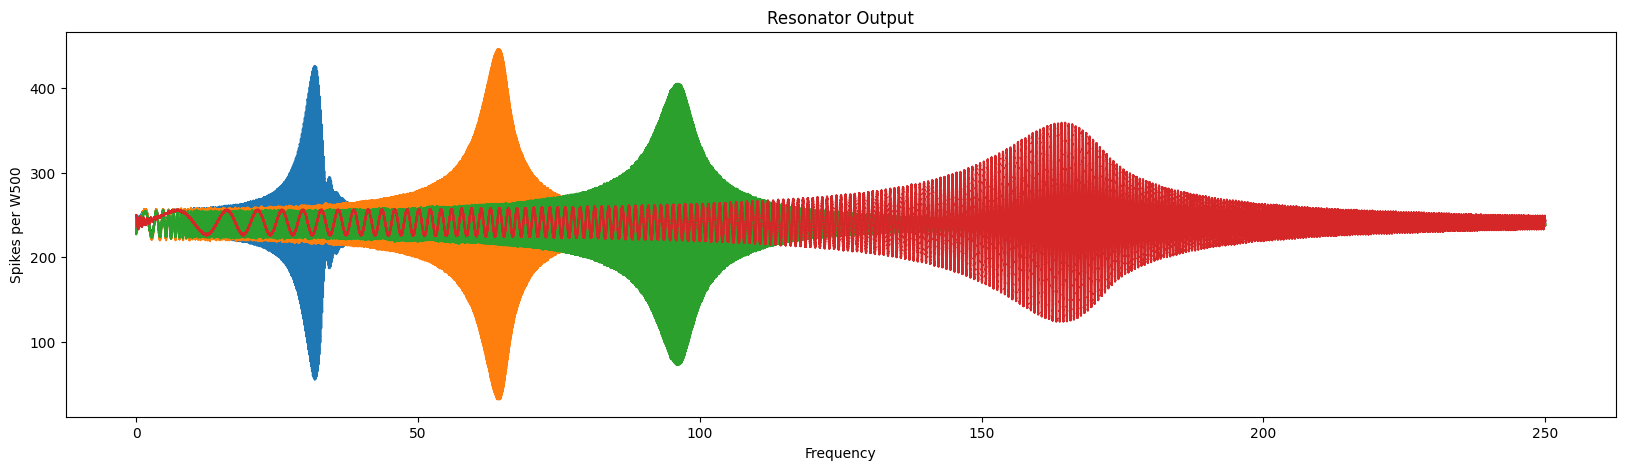

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))

#for one frequency:
resonators_freqs = [30.5,63.6,95.4,163]

#for an evenly spaced frequencies:
#resonators_freqs = [i for i in range(40,260,15)]

#for the exact location of the resonators:
#resonators_freqs = [6.94, 8.98, 10.5, 15.9, 19.5, 25, 30.5, 34.7, 40.2, 46.2,  52.6, 63.6, 69.4, 76.3, 89.8, 95.4, 110, 128, 130, 160, 175, 195, 221, 250]



spectrum = 250
for i, freq in enumerate(resonators_freqs):
    resonator = trained_resonator(freq0=freq)
    resonator.log_out_spikes(-1) # log the spikes emitted from the last neuron
    if freq < 10:
        step = 1/30000
        clk_freq = 15360
    elif 100 > freq >= 10:
        step = 1/30000
        clk_freq = 153600 
    else:
        step = 1/15000
        clk_freq = 1536000         
     
    test_size = int(spectrum / step)
    
    test_resonator_on_chirp(
        resonator,
        start_freq=0,
        test_size=test_size,
        clk_freq=clk_freq,
        step=step)
    plot_emitted_spikes(resonator, spectrum)
    #(do not release this line)modified takes x2 time, but shows legend:
    #plot_emitted_spikes_modified(resonator, spectrum, freq)
    
#playsound("C:\\Users\\user1\\University_ 4th year\\project\\mixkit-correct-answer-reward-952.wav")

# Spectogram Analysis






In [3]:

T =20.0
Fs =400.0
def generate_signal(freqs, T=20.0, Fs=400.0):
    # Number of samples per segment
    N = int(T * Fs)
    
    # Create a time array for one segment
    t = np.linspace(0.0, T, N, endpoint=False)
    
    # Initialize the signal array
    signal = np.array([])

    # Generate sinusoidal signal for each frequency and concatenate
    for freq in freqs:
        s = np.sin(freq * 2 * np.pi * t)
        
        signal = np.append(signal, s)
        
    signal1 = np.concatenate([signal])

    return signal1

def chirp_input_to_spectogram(network, x_stop, nid=-1, label=None):
    spikes_neuron = network.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
    return y_spikes

# Example usage
freqs = [30.0, 60.0, 90.0, 120.0, 150.0, 180.0]
sinus_signals = generate_signal(freqs) # output is one vector of N sine waves put one after the other


resonator_a = trained_resonator(freq0=95.4)
resonator_a.log_out_spikes(-1) # log the spikes emitted from the last neuron
test_size = int(spectrum / step)
    
test_resonator_on_chirp(
    resonator_a,
    start_freq=0,
    test_size=test_size,
    clk_freq=153600,
    step=step)

resonator_b = trained_resonator(freq0=163)
resonator_b.log_out_spikes(-1) # log the spikes emitted from the last neuron
test_size = int(spectrum / step)
    
test_resonator_on_chirp(
    resonator_b,
    start_freq=0,
    test_size=test_size,
    clk_freq=1536000,
    step=step)


chirp_output_a = chirp_input_to_spectogram(resonator_a, spectrum) 
chirp_output_b = chirp_input_to_spectogram(resonator_b, spectrum)
min_value = min(len(chirp_output_a), len(chirp_output_b))

chirp_output_sig_sum = abs(chirp_output_a[:min_value]) + abs(chirp_output_b[:min_value])

95.4 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_95.4.json
Thetas:  [-117.549, -100.74, -96.393, -85.843] , Weights: [387.993, 160.185, 197.341, 190.822, 177.199] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  95.4 f_clk = 153600 Leakage Period is: 15
160 Type:  <class 'int'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_160.json
Thetas:  [-19.184, -17.323, -15.152, -15.803] , Weights: [63.808, 26.451, 34.141, 30.497, 31.678] , Leakage Factor:   4 , Clock Frequency:  1536000
f is:  163 f_clk = 1536000 Leakage Period is: 92


3749501
10713


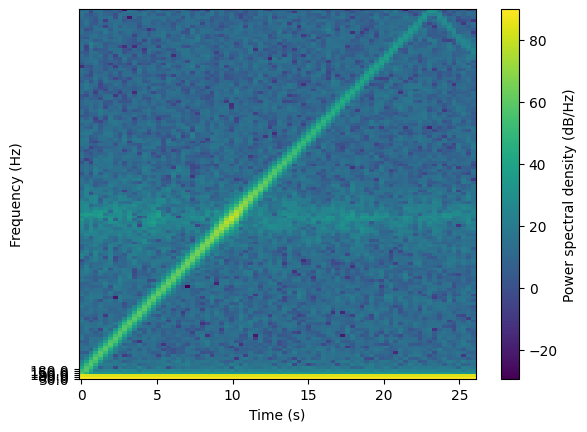

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters for the spectrogram
window_size = 256  # Window size for the FFT
overlap    = 128  # Overlap between windows
# Window the signal
"""window = np.hanning(window_size)
windows = [sinus_signals[i:i+window_size] * window for i in range(0, len(sinus_signals)-window_size, window_size-overlap)]
print((sinus_signals.size))"""
print((chirp_output_b.size))

chirp_signal_sliced = ((chirp_output_a[::350]))
window = np.hanning(window_size)
windows = [chirp_signal_sliced[i:i+window_size] * window for i in range(0, len(chirp_signal_sliced)-window_size, window_size-overlap)]

print((chirp_signal_sliced.size))


# Compute the FFT for each window
spectrogram = [np.abs(np.fft.rfft(win))**2 for win in windows]

# Transpose the result to have time on the x-axis and frequency on the y-axis
spectrogram = np.array(spectrogram).T

# Plot the spectrogram
frequencies = np.fft.rfftfreq(window_size, d=1.0/Fs)
time = np.arange(len(spectrogram[0])) * (window_size - overlap) / Fs
plt.pcolormesh(time, frequencies, 10 * np.log10(spectrogram))
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Power spectral density (dB/Hz)")
#plt.yticks(30+30*np.arange(len(freqs)), freqs)
plt.yticks(np.arange(len(freqs)), freqs)

plt.ylim([0, Fs/2.])

plt.show()

In [6]:
from scipy import signal


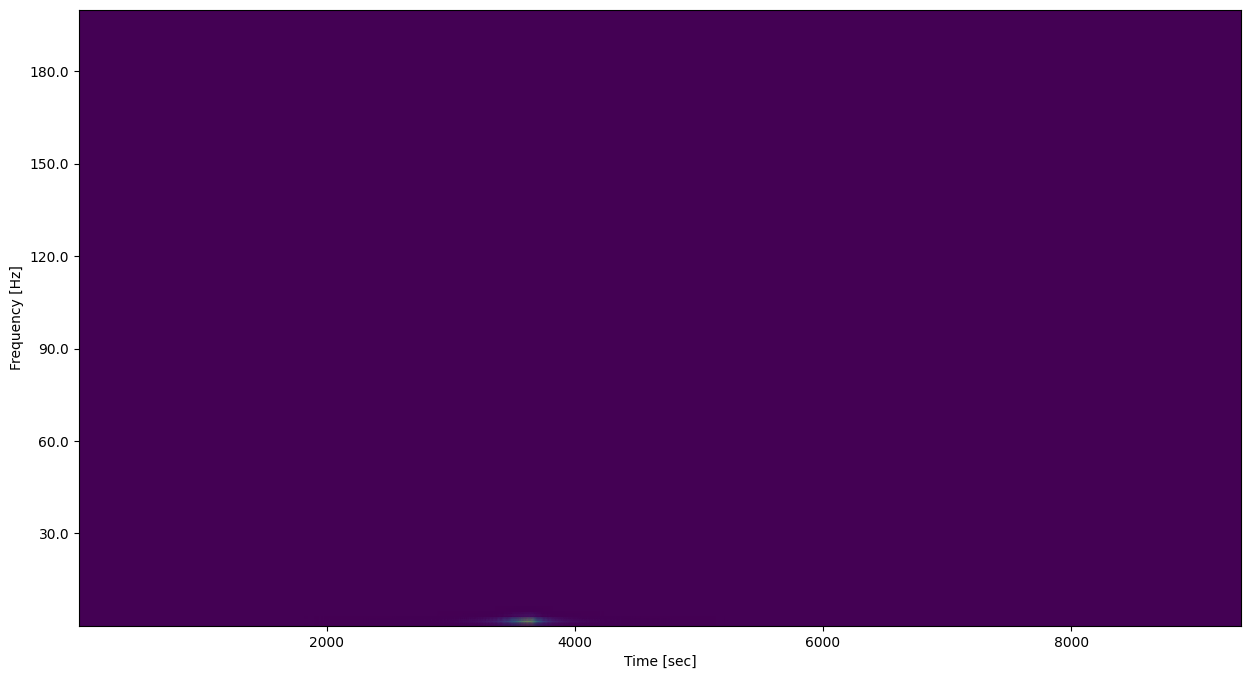

In [69]:
f, t1, Sxx = signal.spectrogram(chirp_output_a, Fs)
plt.figure(figsize=(15,8))
plt.pcolormesh(t1, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yticks(30 +30*np.arange(len(freqs)), freqs)
plt.ylim([0, 200])
plt.show()#

In [5]:
resonator_a = trained_resonator(freq0=95.4)
resonator_a.log_out_spikes(-1) # log the spikes emitted from the last neuron
test_size = int(spectrum / step)
    
test_resonator_on_chirp(
    resonator_a,
    start_freq=0,
    test_size=test_size,
    clk_freq=153600,
    step=step)

resonator_b = trained_resonator(freq0=163)
resonator_b.log_out_spikes(-1) # log the spikes emitted from the last neuron
test_size = int(spectrum / step)
    
test_resonator_on_chirp(
    resonator_b,
    start_freq=0,
    test_size=test_size,
    clk_freq=1536000,
    step=step)


chirp_output_a = chirp_input_to_spectogram(resonator_a, spectrum) 
chirp_output_b = chirp_input_to_spectogram(resonator_b, spectrum)

95.4 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_95.4.json
Thetas:  [-117.549, -100.74, -96.393, -85.843] , Weights: [387.993, 160.185, 197.341, 190.822, 177.199] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  95.4 f_clk = 153600 Leakage Period is: 15
160 Type:  <class 'int'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_160.json
Thetas:  [-19.184, -17.323, -15.152, -15.803] , Weights: [63.808, 26.451, 34.141, 30.497, 31.678] , Leakage Factor:   4 , Clock Frequency:  1536000
f is:  163 f_clk = 1536000 Leakage Period is: 92


In [19]:
#step = 1/30000

resonator_d = trained_resonator(freq0=30.5)
resonator_d.log_out_spikes(-1) # log the spikes emitted from the last neuron
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator_d,
    start_freq=0,
    test_size=test_size,
    clk_freq=153600,
    step=step)

resonator_c = trained_resonator(freq0=63.6)
resonator_c.log_out_spikes(-1) # log the spikes emitted from the last neuron
test_size = int(spectrum / step)
    
test_resonator_on_chirp(
    resonator_c,
    start_freq=0,
    test_size=test_size,
    clk_freq=153600,
    step=step)


chirp_output_c = chirp_input_to_spectogram(resonator_c, spectrum) 
chirp_output_d = chirp_input_to_spectogram(resonator_d, spectrum)

30.5 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_30.5.json
Thetas:  [-37.124, -32.549, -29.814, -29.008] , Weights: [123.204, 50.851, 64.454, 59.25, 58.383] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  30.5 f_clk = 153600 Leakage Period is: 49
63.6 Type:  <class 'float'>
C:\Users\pariz\Project\SNN-SCTN\filters4_xi0\united_filters\f_63.6.json
Thetas:  [-98.054, -70.205, -64.087, -57.686] , Weights: [294.356, 103.068, 140.527, 124.915, 116.543] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  63.6 f_clk = 153600 Leakage Period is: 23


[254. 255. 256. 256. 256. 256. 257. 257. 258. 259. 260. 261. 263. 266.
 271. 277. 292. 321. 392. 403. 337. 287. 269. 261. 255. 253. 250. 248.
 247. 246. 245. 245. 244. 244. 243. 243. 243. 242. 242. 242. 242. 241.
 241. 241. 241. 241. 241. 241. 241. 241.]
[251. 256. 249. 256. 256. 256. 256. 256. 257. 257. 257. 258. 258. 258.
 259. 259. 260. 261. 262. 263. 264. 266. 268. 270. 273. 277. 282. 289.
 298. 311. 328. 349. 359. 358. 335. 304. 287. 277. 271. 267. 263. 260.
 258. 256. 254. 253. 252. 251. 250. 250.]
50
[[251. 256. 249. 256. 256. 256. 256. 256. 257. 257. 257. 258. 258. 258.
  259. 259. 260. 261. 262. 263. 264. 266. 268. 270. 273. 277. 282. 289.
  298. 311. 328. 349. 359. 358. 335. 304. 287. 277. 271. 267. 263. 260.
  258. 256. 254. 253. 252. 251. 250. 250.]
 [254. 255. 256. 256. 256. 256. 257. 257. 258. 259. 260. 261. 263. 266.
  271. 277. 292. 321. 392. 403. 337. 287. 269. 261. 255. 253. 250. 248.
  247. 246. 245. 245. 244. 244. 243. 243. 243. 242. 242. 242. 242. 241.
  241. 241. 

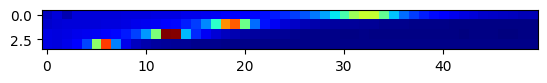

In [22]:


min_value = min(len(chirp_output_a), len(chirp_output_b), len(chirp_output_c), len(chirp_output_d))
#chirp_output_sig_sum = (chirp_output_a[:min_value]) + (chirp_output_b[:min_value])
k= 74990

a = np.maximum.reduceat((chirp_output_a[:min_value]), np.arange(0, len((chirp_output_a[:min_value])), k))
b = np.maximum.reduceat((chirp_output_b[:min_value]), np.arange(0, len((chirp_output_b[:min_value])), k))
c = np.maximum.reduceat((chirp_output_c[:min_value]), np.arange(0, len((chirp_output_c[:min_value])), k))
d = np.maximum.reduceat((chirp_output_d[:min_value]), np.arange(0, len((chirp_output_d[:min_value])), k))
#max_values = np.maximum.reduceat(N, np.arange(0, len(N), k))
print(a)
print(b)
#output = [(chirp_output_a[:min_value]), (chirp_output_b[:min_value])]
output_of_max =[b,a,c,d]

k= 74990
#differences = np.diff(output, n=k)
#max_values = np.maximum.reduceat(N, np.arange(0, len(N), k))

#k=10
N=4
#T = min_value
T =50
spikegram = np.zeros((N, T))
for i, resonator_output in enumerate(output_of_max):
    spikegram[i, :] = (output_of_max[i])



print(T)
#spikegram = [(chirp_output_a[:min_value]), (chirp_output_b[:min_value])]
print(spikegram)
plt.imshow(spikegram, cmap = 'jet')




#74990












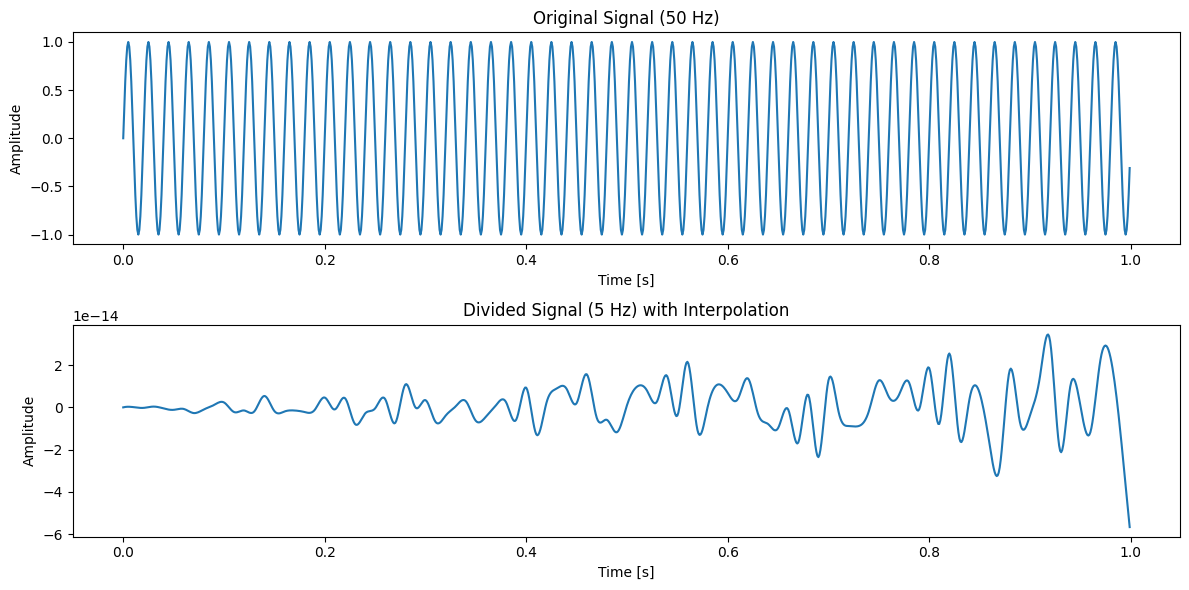

In [68]:

import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# הגדרות
original_freq = 50  # תדר מקורי של 50 הרץ
sampling_rate = 1000  # קצב דגימה של 1000 דגימות לשניה
duration = 1  # אורך האות בשניות
divide_factor = 10  # מחלק תדר של 10

# יצירת אותות
time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)  # יצירת מרווחי זמן של 1 שניה
original_signal = np.sin(2 * np.pi * original_freq * time)  # אות סינוסואידי עם התדר המקורי

# סימולציה של מחלק תדר
divided_signal = original_signal[::divide_factor]

# יצירת מרווחי זמן לאות המחולק
divided_time = time[::divide_factor]

# אינטרפולציה כדי לשמור על רציפות האות המחולק
interp_func = interp1d(divided_time, divided_signal, kind='cubic', fill_value="extrapolate")
continuous_time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
continuous_signal = interp_func(continuous_time)

# גרפים
plt.figure(figsize=(12, 6))

# גרף האות המקורי
plt.subplot(2, 1, 1)
plt.plot(time, original_signal)
plt.title("Original Signal (50 Hz)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

# גרף האות המחולק
plt.subplot(2, 1, 2)
plt.plot(continuous_time, continuous_signal)
plt.title("Divided Signal (5 Hz) with Interpolation")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()
